In [2]:
from IPython.display import Image
import os
from scipy import misc
from scipy import ndimage
from scipy.misc import toimage
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('tf')


from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Reshape
import glob

from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import math

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
ridge = Ridge(alpha=2) # need to justify this value :::: RIDGE REGRESSION

def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]


def load_images_by_filename(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    #return images
    return houses

def rmse(predictions,targets):
    return np.sqrt(((predictions - targets)**2).mean())

def percentwithin10(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets[i]) < 0.10 * targets[i]:
            count+=1;
    return count / len(targets);

def percentwithin10_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.10 * targets[i]:
            count+=1
    print ('total count ' + str(count)+ ' out of ' + str(len(targets)))
    return count / len(targets);

def load_images_to_map(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    return houses


def get_median_error(pred, truth):
    vals = []
    for i in range(0,len(pred)):
        err = math.fabs(pred[i] - truth[i])
        percent = err / truth[i]
        vals.append(percent)
    return np.median(vals)
    
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 

D:\Anaconda3_10\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def load_dataframe():
    #load the dataframe

    # read in data about houses...clean data, normalize, and bring in zip code medians
    path = "D:/thesis/*.csv"
    allFiles = glob.glob(path)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)

    frame.columns = ['SALE', 'DATE', 'PROP_TYPE', 'ADDRESS', 'CITY', 'STATE',
           'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'DAYS_ON_MARKET', 'DL_SQFT', 'HOA', 'STATUS',
           'TIME1', 'TIME2',
           'URL',
           'SOURCE', 'MLS', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE']

    df2 = frame[['DATE','DAYS_ON_MARKET','DL_SQFT','MLS','ZIP','CITY','PRICE','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE']]


    df2 = df2.drop_duplicates() 
    df2 = df2[np.isfinite(df2['PRICE'])]
    df2 = df2[np.isfinite(df2['BEDS'])]
    df2 = df2[np.isfinite(df2['BATHS'])]
    df2 = df2[np.isfinite(df2['YEAR_BUILT'])]
    df2 = df2[np.isfinite(df2['MLS'])]
    df2['HOA'] = df2['HOA'].fillna(0)

    logAge = np.log(2019 - df2.YEAR_BUILT)
    df2['logAge'] = logAge

    df2['LOT_SIZE'] = df2['LOT_SIZE'].fillna(df2['LOT_SIZE'].median())

    df2.loc[df2.ZIP == 46001,'ZIP'] = 46168
    df2.loc[df2.ZIP == 46067,'ZIP'] = 46077
    df2.loc[df2.CITY == 'Noblesville','ZIP'] = 46062

    df_medians = pd.read_csv("D:/thesis/medians/Book3.csv", index_col = None, header = None, names = ['ZIP','b','c','d', 'MEDIAN'])
    del df_medians['b']
    del df_medians['c']
    del df_medians['d']

    df4 = pd.merge(df2, df_medians, on='ZIP', how='left')

    df4 = df4.dropna()
    df4.MLS = df4.MLS.astype('int32')
    df4.MLS = df4.MLS.astype(str)

    # MUST DO THIS POST SPLIT!!!!!!!!!!!!!!!!!!!!!!
    #######################################################################
    #df4[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
    #       'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.fit_transform(df4[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
    #       'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS_ON_MARKET']])
    #######################################################################3
    #remove price outliers
    df4 = df4[df4.PRICE <= 800000]
    df4 = df4[df4.PRICE >= 120000]
    # fix this single zip error ~!!!!!!!!!!!!!!CHECK THIS 
    #df4.MEDIAN[df4.ZIP == 46203] = 60200  
    
    return df4




def load_image_map():
    picfiles = glob.glob('d:/house_images_2/**/*.jpg', recursive=True)
    h = load_images_to_map(picfiles)
    return h





In [4]:
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold 
from keras.preprocessing import image

from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
kf = KFold(n_splits= 10, shuffle = True)

from sklearn.metrics import roc_curve, auc

def split_pos_neg(x):

        if x < 0:
            return 0
        else:
            return 1


def create_image_split(df, h):   # takes dataframe and image map
    # 
    #   create lists for pics, MLS, and price
    #   order is maintained
    pics = []
    nums = []
    prices = []
    df4 = df
    for key in list(h):
        val = df4.where(df4.MLS == key).dropna() 
        if val.size != 0 and math.isinf(val.PRICE.item()) == False:
            resized = misc.imresize(h[key], (224, 224)).astype('float32')
  #          resized = misc.imresize(h[key], (128, 192)).astype('float32')
            prices.append(val.PRICE.astype('float32').item())
            pics.append(resized)
            nums.append(key)

    # save them as numpy arrays

    nums = np.array(nums)
    pics = np.array(pics)
    prices = np.array(prices)
    
    return nums, pics, prices    

In [5]:
house_data = load_dataframe()
features= ['MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']
house_data = house_data.dropna()
X = house_data[features]
y = house_data.PRICE

In [6]:
#load best

best = joblib.load('gbr.p') 

In [7]:
data_features = ['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']
# make predictions about price from best regressor

best.fit(X[data_features], X.PRICE)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=8, max_features=0.3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=30,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [8]:
#calculate residuals as percent of sale price

df2 = X
df2['preds'] = best.predict(X[data_features])
df2['resids'] = (X.PRICE - X.preds) / X.PRICE
df2['errors'] = X.PRICE - X.preds
#create classes from residuals

df2['CLASS'] = df2['resids'].apply(split_pos_neg)

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
df2.head()

,MLS,PRICE,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS_ON_MARKET,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,MEDIAN,preds,resids,errors,CLASS
0,21507042,295000.0,5.0,3.0,3892.0,14374.0,167.0,1994.0,35.0,40.004712,-86.161206,3.218876,317906.0,329553.809380,-0.117132,-34553.809380,0
1,21504853,346500.0,4.0,2.5,3923.0,16117.0,139.0,1990.0,29.0,39.972871,-86.165201,3.367296,317906.0,345441.631422,0.003054,1058.368578,1
3,21512685,400000.0,4.0,4.0,5124.0,18295.0,127.0,1996.0,50.0,39.936647,-86.228057,3.135494,317906.0,451063.194295,-0.127658,-51063.194295,0
4,21517865,501555.0,5.0,5.0,7732.0,26136.0,125.0,2000.0,50.0,39.938926,-86.219860,2.944439,317906.0,631955.629869,-0.259993,-130400.629869,0
5,21511272,484000.0,3.0,3.5,5462.0,69696.0,135.0,1983.0,19.0,39.932524,-86.171818,3.583519,317906.0,520199.346743,-0.074792,-36199.346743,0


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

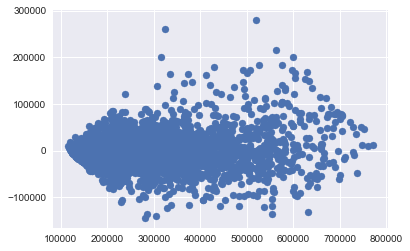

In [11]:
ax = plt.scatter(x = "preds", y = "errors", data = df2 )

In [12]:
house_data = load_dataframe()
features= ['MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']
house_data = house_data.dropna()
X = house_data[features]
y = house_data.PRICE

data_features = ['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']
# make predictions about price from best regressor

best.fit(X[data_features], X.PRICE)

#calculate residuals as percent of sale price

df2 = X
df2['preds'] = best.predict(X[data_features])
df2['resids'] = (X.PRICE - X.preds) / X.PRICE
df2['errors'] = X.PRICE - X.preds
#create classes from residuals

df2['CLASS'] = df2['resids'].apply(split_pos_neg)


D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
image_map = load_image_map()
nums, pics, prices = create_image_split(X, image_map)

encoder = ResNet50(include_top = False, weights='imagenet', input_shape = (224, 224, 3))

#populate features into map from resnet

img_pred_map = { }
pro_pics = preprocess_input(pics)
#pro_pics = pics / 255
features = encoder.predict(pro_pics)
#features = encoder.predict(pics)
#features = np.reshape(features,(5408,12288))
for i in range(len(pro_pics)):
#for i in range(len(pics)):
    img_pred_map[nums[i]] = features[i].flatten()

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:83: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [14]:
#create data frame of resnet features
image_frame = pd.DataFrame.from_dict(img_pred_map, orient = 'index')

In [15]:
#PCA- MERGE FRAMES
n_components= 50
pca = PCA(n_components)
pca_result = pca.fit_transform(image_frame.values)

print ('Cumulative explained variation for principal components: {}'
           .format(np.sum(pca.explained_variance_ratio_)))

pca = PCA(n_components)
#pca_result_50 = pca_50.fit_transform(merged.values)
pca_frame = pd.DataFrame(pca.fit_transform(pca_result),
                         columns=['PCA%i' % i for i in range(n_components)], index=image_frame.index)

merged = X.merge(pca_frame, left_on = 'MLS', right_index = True, how = 'inner' )

Cumulative explained variation for principal components: 0.7122313198802873


In [16]:
# NO PCA - MERGE FRAMES
# merged = X.merge(image_frame, left_on = 'MLS', right_index = True, how = 'inner' )

In [17]:
# merged.head()

In [18]:
features = ['MLS','PRICE','DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN','preds','resids','CLASS','range','errors']

cols = [col for col in merged.columns if col not in features]

y = merged.CLASS

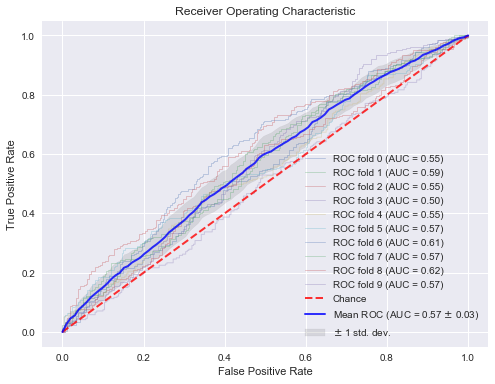

In [19]:
############################################
# ROC/AUC CODE Code for figure
# from (“Receiver Operating Characteristic (ROC)
# with cross validation — scikit-learn 0.20.1 documentation,” 2018):
# 
# 
#
############################################

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp


fig = plt.figure()
X = merged[cols].values
y = merged['CLASS'].values

cv = StratifiedKFold(n_splits=10)
classifier = GradientBoostingClassifier()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):

    estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
    #grid_search.fit(train_X[cols], train_ground )
    probas_ = estimator.fit(X[train], y[train]).predict_proba(X[test])
    
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
fig.set_size_inches(8, 6)
plt.savefig('foo.png')
plt.show()